<a href="https://colab.research.google.com/github/mohammed-Emad/E2E-MLT/blob/master/Ocr_task_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import json 
from os import path

#Try Pre-trained model 'Multi-Language Scene Text'

In [ ]:
!pip -q install arabic_reshaper python-bidi 

In [ ]:
!git clone https://github.com/mohammed-Emad/E2E-MLT.git 

Cloning into 'E2E-MLT'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 204 (delta 2), reused 7 (delta 2), pack-reused 194
Receiving objects: 100% (204/204), 16.48 MiB | 9.13 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [ ]:
%cd E2E-MLT

/content/E2E-MLT


In [ ]:
#download model
!wget http://ptak.felk.cvut.cz/public_datasets/SyntText/e2e-mlt.h5

--2022-07-01 21:19:26--  http://ptak.felk.cvut.cz/public_datasets/SyntText/e2e-mlt.h5
Resolving ptak.felk.cvut.cz (ptak.felk.cvut.cz)... 147.32.84.14
Connecting to ptak.felk.cvut.cz (ptak.felk.cvut.cz)|147.32.84.14|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105505238 (101M)
Saving to: ‘e2e-mlt.h5’

e2e-mlt.h5          100%[===================>] 100.62M  14.4MB/s    in 8.4s    

2022-07-01 21:19:36 (11.9 MB/s) - ‘e2e-mlt.h5’ saved [105505238/105505238]



In [ ]:
#download model 
!wget http://ptak.felk.cvut.cz/public_datasets/SyntText/e2e-mltrctw.h5

--2022-07-01 21:29:38--  http://ptak.felk.cvut.cz/public_datasets/SyntText/e2e-mltrctw.h5
Resolving ptak.felk.cvut.cz (ptak.felk.cvut.cz)... 147.32.84.14
Connecting to ptak.felk.cvut.cz (ptak.felk.cvut.cz)|147.32.84.14|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108285548 (103M)
Saving to: ‘e2e-mltrctw.h5’

e2e-mltrctw.h5      100%[===================>] 103.27M  13.8MB/s    in 9.0s    

2022-07-01 21:29:50 (11.4 MB/s) - ‘e2e-mltrctw.h5’ saved [108285548/108285548]



In [ ]:
import cv2
import numpy as np

from nms import get_boxes

from models import ModelResNetSep2
import net_utils

from ocr_utils import ocr_image
from data_gen import draw_box_points
import torch

import argparse

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
from google.colab.patches import cv2_imshow
import arabic_reshaper
from bidi.algorithm import get_display

f = open('codec.txt', 'r', encoding='utf-8')
codec = f.readlines()[0]
f.close()

def resize_image(im, max_size = 1585152, scale_up=True):

  if scale_up:
    image_size = [im.shape[1] * 3 // 32 * 32, im.shape[0] * 3 // 32 * 32]
  else:
    image_size = [im.shape[1] // 32 * 32, im.shape[0] // 32 * 32]
  while image_size[0] * image_size[1] > max_size:
    image_size[0] /= 1.2
    image_size[1] /= 1.2
    image_size[0] = int(image_size[0] // 32) * 32
    image_size[1] = int(image_size[1] // 32) * 32


  resize_h = int(image_size[1])
  resize_w = int(image_size[0])


  scaled = cv2.resize(im, dsize=(resize_w, resize_h))
  return scaled, (resize_h, resize_w)


def e2e_test(img_path):

  font2 = ImageFont.truetype("Arial-Unicode-Regular.ttf", 18)

  net = ModelResNetSep2(attention=True)
  net_utils.load_net("e2e-mlt.h5", net)
  net = net.eval()

  if 1:
    print('Using cuda ...')
    net = net.cuda()

  frame_no = 0
  with torch.no_grad():
      
      ret = True
      im = cv2.imread(img_path)

      if ret==True:
        im_resized, (ratio_h, ratio_w) = resize_image(im, scale_up=False)
        images = np.asarray([im_resized], dtype=np.float)
        images /= 128
        images -= 1
        im_data = net_utils.np_to_variable(images, is_cuda=1).permute(0, 3, 1, 2)
        seg_pred, rboxs, angle_pred, features = net(im_data)

        rbox = rboxs[0].data.cpu()[0].numpy()
        rbox = rbox.swapaxes(0, 1)
        rbox = rbox.swapaxes(1, 2)

        angle_pred = angle_pred[0].data.cpu()[0].numpy()


        segm = seg_pred[0].data.cpu()[0].numpy()
        segm = segm.squeeze(0)

        draw2 = np.copy(im_resized)
        boxes =  get_boxes(segm, rbox, angle_pred, 0.4)

        img = Image.fromarray(draw2)
        draw = ImageDraw.Draw(img)

        #if len(boxes) > 10:
        #  boxes = boxes[0:10]

        out_boxes = []
        for box in boxes:

          pts  = box[0:8]
          pts = pts.reshape(4, -1)

          det_text0, conf, dec_s = ocr_image(net, codec, im_data, box)
          org_text = det_text0

          if len(det_text0) == 0:
             continue

          get_arabic_char = max([ord(i) for i in det_text0]) 
          if  get_arabic_char >128:
              det_text0 = det_text0[::-1]
              reshaped_text = arabic_reshaper.reshape(det_text0)
              det_text0 = get_display(reshaped_text)
          

          width, height = draw.textsize(det_text0, font=font2)
          center =  [box[0], box[1]]
          draw.text((center[0], center[1]), det_text0, fill = (255,0,0),font=font2)
          out_boxes.append(box)
          print(org_text)

        im = np.array(img)
        for box in out_boxes:
          pts  = box[0:8]
          pts = pts.reshape(4, -1)
          draw_box_points(im, pts, color=(0, 255, 0), thickness=1)

        cv2_imshow(im)


In [ ]:
!wget 'https://i.pinimg.com/originals/ab/95/0a/ab950a225dc590d7e5308e116cc3b9c7.jpg'

--2022-07-01 21:26:42--  https://i.pinimg.com/originals/ab/95/0a/ab950a225dc590d7e5308e116cc3b9c7.jpg
Resolving i.pinimg.com (i.pinimg.com)... 23.54.56.217, 2600:1413:b000:28f::1931, 2600:1413:b000:28b::1931, ...
Connecting to i.pinimg.com (i.pinimg.com)|23.54.56.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89467 (87K) [image/jpeg]
Saving to: ‘ab950a225dc590d7e5308e116cc3b9c7.jpg’

ab950a225dc590d7e53 100%[===================>]  87.37K  --.-KB/s    in 0.02s   

2022-07-01 21:26:42 (5.04 MB/s) - ‘ab950a225dc590d7e5308e116cc3b9c7.jpg’ saved [89467/89467]



e2e-mlt.h5
Using cuda ...
نلاحاصاودسقتإل
ةلولامتايركد
ذيسنيال
الوهف
ةلاركاذلا
ةيوقتلامك
awawdeh
@zmia
Des
ةيكذ
انلابص
نيالو


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4256: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4194: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True i

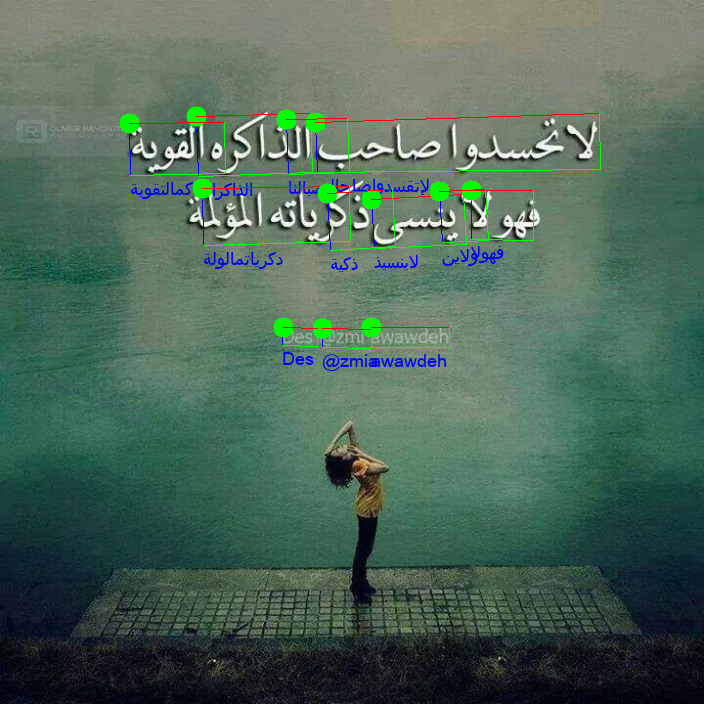

In [ ]:
e2e_test('ab950a225dc590d7e5308e116cc3b9c7.jpg')

**Not Good??**


**E2E-MLT is actually a very powerful model, but the Arabic character recognition system inside is still a bit bad.**

**For example, the form often fails to recognize Arabic numerals, or even locate them.**

# Easyocr  {OCR with 80+ supported languages}

In [ ]:
!pip -q install easyocr 

     |████████████████████████████████| 70.8 MB 19 kB/s 
     |████████████████████████████████| 47.6 MB 1.9 MB/s 


In [ ]:
from easyocr import Reader
from google.colab.patches import cv2_imshow
import cv2 


def eng_ocr(image_path,out_image):
  # break the input languages into a comma separated list
  font2 = ImageFont.truetype("Arial-Unicode-Regular.ttf", 32)
  langs = ["ar","en"]
  
  #load the input image from disk
  image = cv2.imread(image_path)
  #OCR the input image using EasyOCR
  print("[INFO] OCR'ing input image...")
  draw2 = np.copy(image)
  reader  = Reader(langs, gpu=True)
  results = reader.readtext(image)

  img = Image.fromarray(draw2)
  draw = ImageDraw.Draw(img)
  new_boxes = []
  filename=out_image
  for (bbox, text, prob) in results:
    # display the OCR'd text and associated probability
    print("[INFO] {:.4f}: {}".format(prob, text))
    # unpack the bounding box
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))
    # cleanup the text and draw the box surrounding the text along
    # with the OCR'd text itself
    
    
    if len(text) == 0:
       continue

    get_arabic_char = max([ord(i) for i in text]) 
    if  get_arabic_char > 128:
              reshaped_text = arabic_reshaper.reshape(text)
              text = get_display(reshaped_text)

    width, height = draw.textsize(text, font=font2)
    center =  [tl[0], tl[1]-42]
    
    draw.text((center[0], center[1]), text, fill = (255,0,0),font=font2)
    new_boxes.append([tl, br])

  # show the output image
  im = np.array(img)
  for tl, br in new_boxes:
      cv2.rectangle(im, tl, br, (0, 255, 0), 2)
  cv2.imwrite(filename, im)
  return im ,results

[INFO] OCR'ing input image...
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete[INFO] 0.4838: لاتحسدوا صاحب الذاكره القوية
[INFO] 0.6953: - المؤلمة
[INFO] 0.6726: فهولاينسى ذكرياته |
[INFO] 0.0260: 035 @zmiana.35


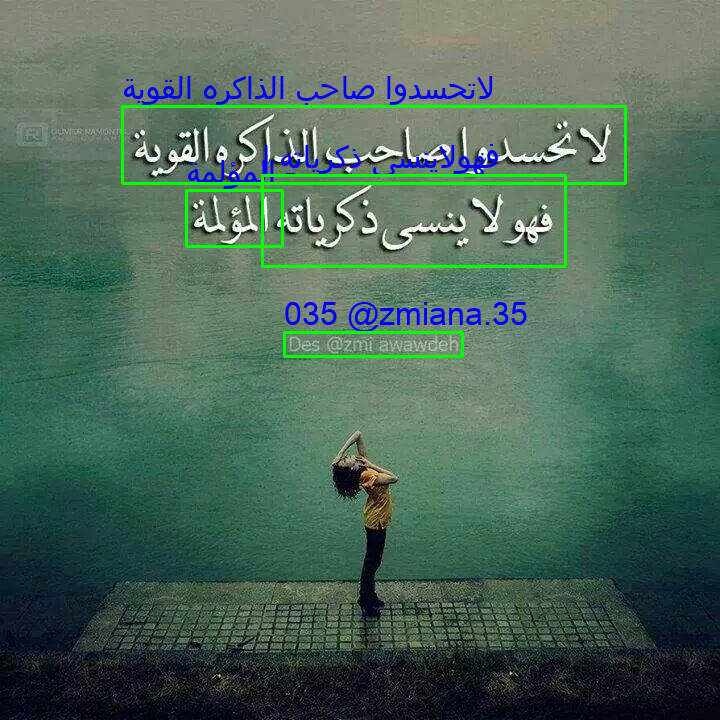

In [ ]:
image_path='/content/E2E-MLT/ab950a225dc590d7e5308e116cc3b9c7.jpg'
out_image='out.jpg'
im ,results = eng_ocr(image_path,out_image)

cv2_imshow(im)